<a href="https://colab.research.google.com/github/BigOyayubi/PyTorchTutorial/blob/master/PyTorch1_1_GettingStarted_06_DataLoading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://torch.classcat.com/2019/06/24/pytorch-1-1-getting-started-data-loading/

このチュートリアルでは、自明ではないデータセットからデータをどのようにロードして前処理/増強するかを見ていきます。

In [0]:
from __future__ import print_function, division
import os
import torch
#CSV解析
import pandas as pd
#scikit-image 画像IOと変換
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
 
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
 
plt.ion()   # interactive mode

![代替テキスト](http://torch.classcat.com/wp-content/uploads/2018/04/pytorch3-tutorial_landmarked_face2.png)

上記のような画像＋目印（CSV）データセットを扱う

In [0]:
#データは
# -- ディレクトリ以下の画像群
# -- CSVファイル
#    -- 画像ファイル名,part_0_x,part_0_y,...,part_67_x,part_67_y
#のような構成

#顔目印データセット向けに独自のデータセットクラスを作成
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""
 
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
 
    def __len__(self):
        return len(self.landmarks_frame)
 
    #読み込みは__getitem__で必要分だけ。一度にメモリにストアされない
    # 目印は[[x0,y0],[x1,y1],...]と並ぶ
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
 
        if self.transform:
            sample = self.transform(sample)
 
        return sample

In [3]:
#データをダウンロードする
!wget https://download.pytorch.org/tutorial/faces.zip
#zipをdata/以下へ解凍
!unzip faces.zip -d data

--2019-09-26 07:38:28--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.103.35, 13.225.103.91, 13.225.103.61, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.103.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip’

faces.zip           100%[===================>]   5.51M  --.-KB/s    in 0.1s    

2019-09-26 07:38:29 (53.5 MB/s) - ‘faces.zip’ saved [5780252/5780252]

Archive:  faces.zip
   creating: data/faces/
  inflating: data/faces/0805personali01.jpg  
  inflating: data/faces/1084239450_e76e00b7e7.jpg  
  inflating: data/faces/10comm-decarlo.jpg  
  inflating: data/faces/110276240_bec305da91.jpg  
  inflating: data/faces/1198_0_861.jpg  
  inflating: data/faces/137341995_e7c48e9a75.jpg  
  inflating: data/faces/1383023626_8a49e4879a.jpg  
  inflating: data/faces/144044282_87cf3ff76e.jpg  
  inflating: data/faces/15260199

0 (324, 215, 3) (68, 2)


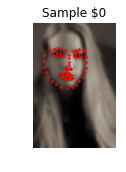

1 (500, 333, 3) (68, 2)


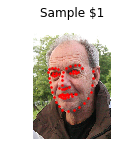

2 (250, 258, 3) (68, 2)


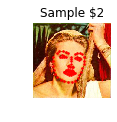

3 (434, 290, 3) (68, 2)


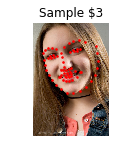

In [4]:
#独自DataLoader用意
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', root_dir='data/faces/')

fig = plt.figure()

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    #scatter : 散布図描画 arg1:x, arg2:y, s:size, marker:マーカーの形, c:色
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

for i in range(len(face_dataset)):
  sample = face_dataset[i]

  print(i, sample['image'].shape, sample['landmarks'].shape)

  ax = plt.subplot(1, 4, i + 1)
  plt.tight_layout()
  ax.set_title('Sample ${}'.format(i))
  ax.axis('off')
  show_landmarks(**sample)

  if i == 3:
    plt.show()
    break;

In [0]:
#各画像のサイズが異なるため、前処理する

#画像を指定サイズへ補正 目印は各xy座標を補正
class Rescale(object):
    """Rescale the image in a sample to a given size.
 
    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
 
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
 
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
 
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
 
        new_h, new_w = int(new_h), int(new_w)
 
        img = transform.resize(image, (new_h, new_w))
 
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]
 
        return {'image': img, 'landmarks': landmarks}

#指定サイズでランダム位置で切り取る
class RandomCrop(object):
    """Crop randomly the image in a sample.
 
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
 
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
 
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
 
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
 
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
 
        image = image[top: top + new_h,
                      left: left + new_w]
 
        landmarks = landmarks - [left, top]
 
        return {'image': image, 'landmarks': landmarks}

#numpy形式からtorch.Tensorへ入れ替え
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
 
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}


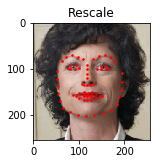

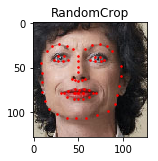

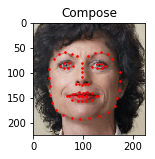

In [6]:
#transformを適用
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
  transformed_sample = tsfrm(sample)

  ax = plt.subplot(1, 3, i + 1)
  plt.tight_layout()
  ax.set_title(type(tsfrm).__name__)
  show_landmarks(**transformed_sample)

plt.show()

In [7]:
#サイズ統一、ランダム切り取りを有効にしたデータセット
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))
 
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
 
    print(i, sample['image'].size(), sample['landmarks'].size())
 
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


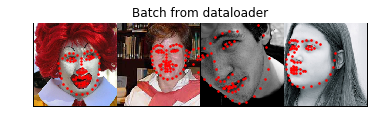

In [8]:
#DataLoaderを活用して、バッチ処理、シャッフル、並列処理を可能にする
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
 
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
 
    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')
 
        plt.title('Batch from dataloader')
 
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())
 
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break